In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

## CSVs

- cards.csv: This file contains information about each Magic the Gathering card, including its name, mana cost, type, text, power, toughness, rarity, and other attributes. This file is essential for clustering analysis as it contains all the necessary information about each card in the dataset.

- legalities.csv: This file contains information about the legality of each card in various Magic the Gathering formats, including the Commander format. This file can be used to filter out cards that are banned in the Commander format and ensure that only legal cards are included in the analysis.


## Explanantion of Columns
- `name`: The name of the card, which may be relevant for identifying clusters based on card names.

- `convertedManaCost`: The converted mana cost of the card, which is a numerical value representing the amount of mana needed to cast the card. This column may be relevant for identifying clusters based on mana cost.

- `colors`: The colors of the card, which may be relevant for identifying clusters based on color identity.

- `type`: The type of the card, which may be relevant for identifying clusters based on card type.

- `text`: The text of the card, which may be relevant for identifying clusters based on card abilities.

- `power`: The power of the card, which is a numerical value representing the strength of the card in combat. This column may be relevant for identifying clusters based on card power.

- `toughness`: The toughness of the card, which is a numerical value representing the resilience of the card in combat. This column may be relevant for identifying clusters based on card toughness.

- `rarity`: The rarity of the card, which may be relevant for identifying clusters based on card value.

- `format`: The format in which the card is legal, which may be relevant for identifying clusters based on card legality.

- `keywords`: The keywords associated with the card, which may be relevant for identifying clusters based on card abilities.

- `edhrecRank`: The EDHREC rank of the card, which is a numerical value representing the popularity of the card in the Commander format. This column may be relevant for identifying clusters based on card popularity.

- `subtypes`: The subtypes of the card, which may be relevant for identifying clusters based on card type.

- `edhrecSaltiness`: The EDHREC saltiness of the card, which is a numerical value representing the perceived power level of the card in the Commander format. This column may be relevant for identifying clusters based on card power.

## Loading Dataset

In [3]:
# Load the "cards.csv" file into a pandas DataFrame
cards = pd.read_csv('cards.csv', low_memory=False)


In [4]:
# Load the "legalities.csv" file into a pandas DataFrame
legalities = pd.read_csv("legalities.csv")


In [5]:
# Merge the "legalities" DataFrame with the "cards" DataFrame
cards = pd.merge(cards, legalities, on="uuid", how="left")

## Cleaning DataFrame

In [6]:
cards = cards[["name","colors","format", "convertedManaCost", "power", "toughness", "rarity", "keywords", "edhrecRank", "types", "edhrecSaltiness"]]


In [7]:
# selecting only cards eligible to play in commander decks
cards = cards[cards['format'] == 'commander']

In [8]:
# N represents no color mainly for lands 
cards['colors'].fillna(value='N', inplace=True)
cards['color_groups'] = cards['colors'].str.count('[A-Z]')

In [9]:
# making power 0 since they are all sorcery, instants, and lands
cards['power'].fillna(value='0', inplace=True)
cards['power'] = pd.to_numeric(cards['power'], errors='coerce')
cards = cards.dropna(subset=['power'])
cards['power'] = cards['power'].astype(int)

In [10]:
# making power 0 since they are all sorcery, instants, and lands
cards['toughness'].fillna(value='0', inplace=True)
# Convert 'toughness' column to string
cards['toughness'] = cards['toughness'].astype(str)

# Drop non-integer values
cards['toughness'] = cards['toughness'].str.replace('[^0-9]', '')

# Convert remaining values to integer
cards['toughness'] = pd.to_numeric(cards['toughness'], errors='coerce')
cards = cards.dropna(subset=['toughness']).astype({'toughness': 'int'})

/var/folders/hn/f_28jr5j09b4_cxwrf6tljjm0000gn/T/ipykernel_27235/2296585571.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  cards['toughness'] = cards['toughness'].str.replace('[^0-9]', '')


In [11]:
# no abilites for specific cards 
cards['keywords'].fillna(value='empty', inplace=True)
cards['amount_of_abilities'] = cards['keywords'].str.count(',') + 1

In [12]:
# dropping cards that are not currently in play
cards.dropna(subset='edhrecRank', inplace=True)

In [13]:
#setting saltiness score to 0 since unknwon the sentiment
cards['edhrecSaltiness'].fillna(value='0', inplace=True)
cards['edhrecSaltiness'] = cards['edhrecSaltiness'].astype(float)

In [14]:
cards.isnull().sum()

name                   0
colors                 0
format                 0
convertedManaCost      0
power                  0
toughness              0
rarity                 0
keywords               0
edhrecRank             0
types                  0
edhrecSaltiness        0
color_groups           0
amount_of_abilities    0
dtype: int64

In [15]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68936 entries, 0 to 719027
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 68936 non-null  object 
 1   colors               68936 non-null  object 
 2   format               68936 non-null  object 
 3   convertedManaCost    68936 non-null  float64
 4   power                68936 non-null  int64  
 5   toughness            68936 non-null  int64  
 6   rarity               68936 non-null  object 
 7   keywords             68936 non-null  object 
 8   edhrecRank           68936 non-null  float64
 9   types                68936 non-null  object 
 10  edhrecSaltiness      68936 non-null  float64
 11  color_groups         68936 non-null  int64  
 12  amount_of_abilities  68936 non-null  int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 7.4+ MB


In [16]:
cards.nunique()

name                   24257
colors                    40
format                     1
convertedManaCost         17
power                     17
toughness                 18
rarity                     6
keywords                1616
edhrecRank             24246
types                     17
edhrecSaltiness          214
color_groups               5
amount_of_abilities        6
dtype: int64

In [17]:
cards['types'].value_counts()

Creature                31740
Instant                  8135
Sorcery                  8087
Enchantment              6891
Artifact                 5450
Land                     4431
Artifact,Creature        2296
Planeswalker             1267
Enchantment,Creature      408
Artifact,Land              87
Tribal,Instant             46
Tribal,Enchantment         34
Tribal,Sorcery             33
Enchantment,Artifact       15
Tribal,Artifact             8
Land,Creature               4
Enchantment,Land            4
Name: types, dtype: int64

In [18]:
cards.isna().sum()

name                   0
colors                 0
format                 0
convertedManaCost      0
power                  0
toughness              0
rarity                 0
keywords               0
edhrecRank             0
types                  0
edhrecSaltiness        0
color_groups           0
amount_of_abilities    0
dtype: int64

## Determining Clusters

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [20]:
# Create a new dataframe for preprocessing without modifying the original dataframe
X = cards.copy()

# One-hot encode the 'rarity' and 'types' columns
ohe = OneHotEncoder()
ohe_df = ohe.fit_transform(X[['rarity', 'types']])
ohe_df = pd.DataFrame(ohe_df.toarray(), columns=ohe.get_feature_names_out(['rarity', 'types']))
X.drop(['rarity', 'types'], axis=1, inplace=True)
ohe_df.index = X.index
X = pd.concat([X, ohe_df], axis=1)

# Scale the numeric columns
scaler = MinMaxScaler()
scaled_cols = scaler.fit_transform(X[['convertedManaCost', 'power', 'toughness', 'edhrecRank', 'edhrecSaltiness']])
scaled_df = pd.DataFrame(scaled_cols, columns=['convertedManaCost', 'power', 'toughness', 'edhrecRank', 'edhrecSaltiness'])
X.drop(['name','format','colors','keywords','convertedManaCost', 'power', 'toughness', 'edhrecRank', 'edhrecSaltiness'], axis=1, inplace=True)
scaled_df.index = X.index
X = pd.concat([X, scaled_df], axis=1)

# Print the head of the new dataframe
X


,color_groups,amount_of_abilities,rarity_bonus,rarity_common,rarity_mythic,rarity_rare,rarity_special,rarity_uncommon,types_Artifact,"types_Artifact,Creature","types_Artifact,Land",types_Creature,types_Enchantment,"types_Enchantment,Artifact","types_Enchantment,Creature","types_Enchantment,Land",types_Instant,types_Land,"types_Land,Creature",types_Planeswalker,types_Sorcery,"types_Tribal,Artifact","types_Tribal,Enchantment","types_Tribal,Instant","types_Tribal,Sorcery",convertedManaCost,power,toughness,edhrecRank,edhrecSaltiness
0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.294118,0.235294,0.773493,0.092466
9,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.294118,0.235294,0.773493,0.092466
18,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3125,0.235294,0.176471,0.622353,0.000000
31,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3125,0.235294,0.176471,0.622353,0.000000
44,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1875,0.058824,0.000000,0.830660,0.047945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718978,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1250,0.058824,0.000000,0.075651,0.047945
718992,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0625,0.058824,0.000000,0.273290,0.000000
719003,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1250,0.058824,0.000000,0.536889,0.027397
719016,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1875,0.058824,0.000000,0.027972,0.030822


/Users/duckman/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/duckman/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/duckman/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/duckman/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


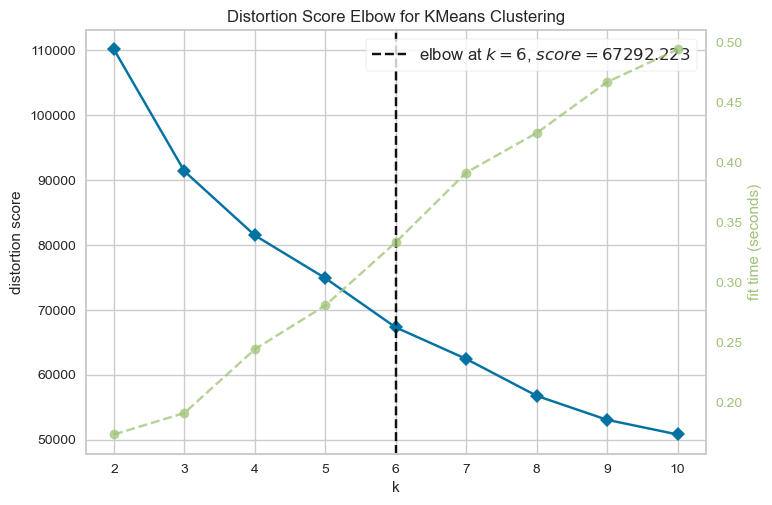

In [21]:
cluster = KElbowVisualizer(KMeans()) 
pipe = make_pipeline(cluster)
pipe.fit(X)
pipe[0].show()
plt.show()

/Users/duckman/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


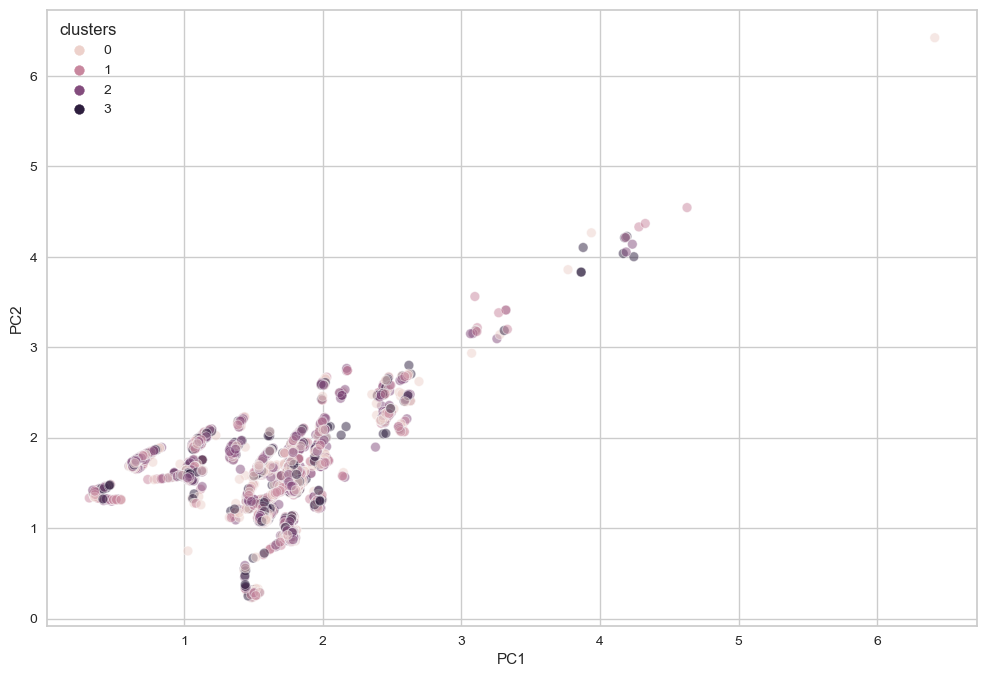

In [22]:
decomp = PCA(n_components=0.9)
cluster = KMeans(n_clusters=4)
pipe = make_pipeline(decomp,cluster)
pipe.fit(X)
values = pipe[:2].transform(X)

pca_labels = [f'PC{idx+1}' for idx, i in enumerate(values.T)]
cards = cards.join(pd.DataFrame(values, columns=pca_labels))

cards['clusters'] = pipe['kmeans'].labels_
X['clusters'] = pipe['kmeans'].labels_

plt.figure(figsize = (12,8))
g = sns.scatterplot(data=cards, x='PC1', y='PC2', hue='clusters', alpha=0.5)

In [23]:
X.columns



Index(['color_groups', 'amount_of_abilities', 'rarity_bonus', 'rarity_common',
       'rarity_mythic', 'rarity_rare', 'rarity_special', 'rarity_uncommon',
       'types_Artifact', 'types_Artifact,Creature', 'types_Artifact,Land',
       'types_Creature', 'types_Enchantment', 'types_Enchantment,Artifact',
       'types_Enchantment,Creature', 'types_Enchantment,Land', 'types_Instant',
       'types_Land', 'types_Land,Creature', 'types_Planeswalker',
       'types_Sorcery', 'types_Tribal,Artifact', 'types_Tribal,Enchantment',
       'types_Tribal,Instant', 'types_Tribal,Sorcery', 'convertedManaCost',
       'power', 'toughness', 'edhrecRank', 'edhrecSaltiness', 'clusters'],
      dtype='object')

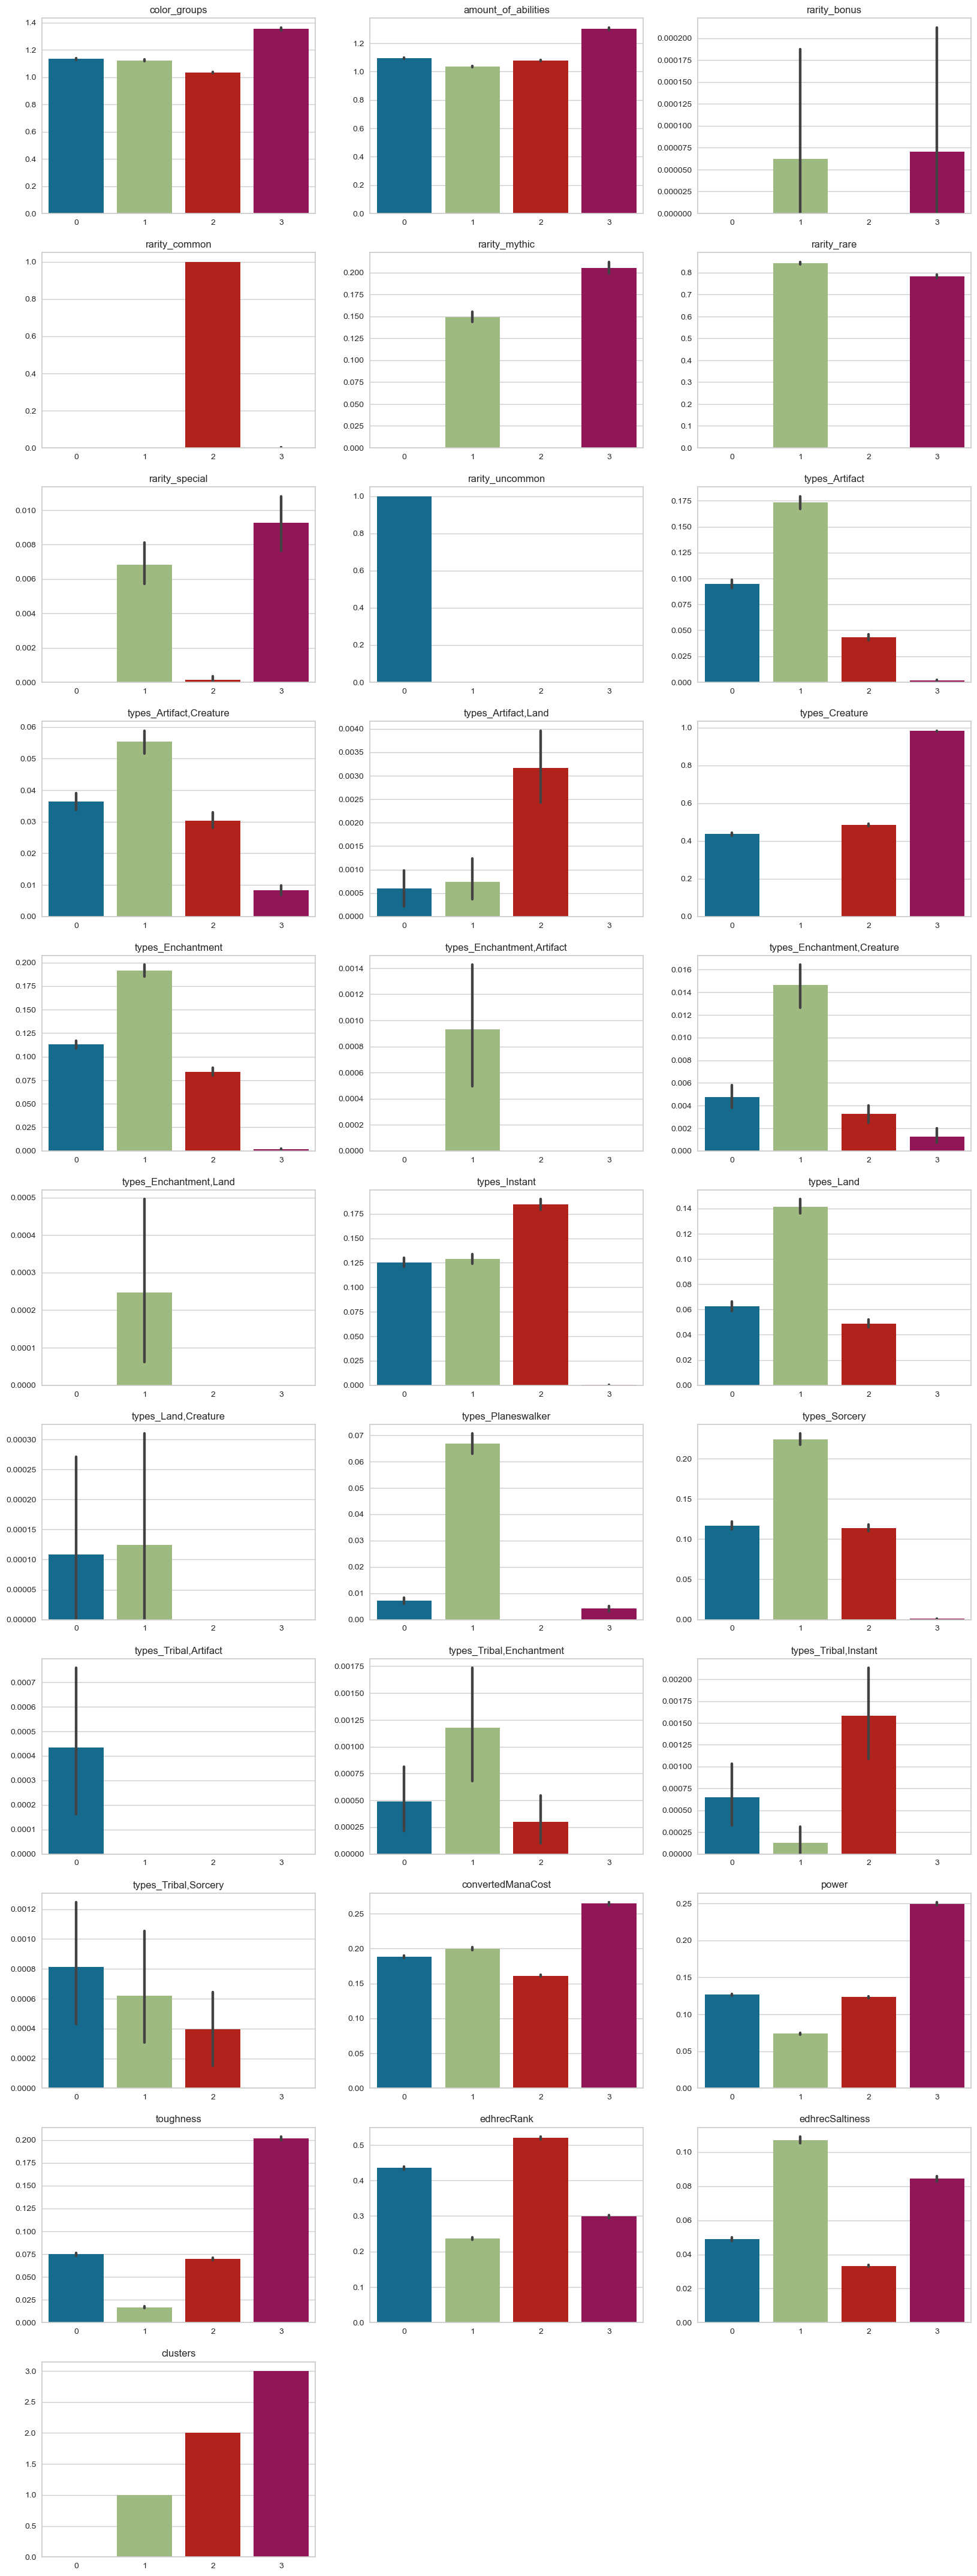

In [24]:
import math

var_list =['color_groups', 'amount_of_abilities', 'rarity_bonus', 'rarity_common',
       'rarity_mythic', 'rarity_rare', 'rarity_special', 'rarity_uncommon',
       'types_Artifact', 'types_Artifact,Creature', 'types_Artifact,Land',
       'types_Creature', 'types_Enchantment', 'types_Enchantment,Artifact',
       'types_Enchantment,Creature', 'types_Enchantment,Land', 'types_Instant',
       'types_Land', 'types_Land,Creature', 'types_Planeswalker',
       'types_Sorcery', 'types_Tribal,Artifact', 'types_Tribal,Enchantment',
       'types_Tribal,Instant', 'types_Tribal,Sorcery', 'convertedManaCost',
       'power', 'toughness', 'edhrecRank', 'edhrecSaltiness', 'clusters']

rows = math.ceil(len(var_list)/3)

fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data=X, x='clusters', y=i, ax=ax)
    ax.set(xlabel='', ylabel='', title=i)

for i in axs.flat[::-1][:rows*3-len(var_list)]:
    i.set_axis_off()

plt.show()

In [29]:
cards.groupby('clusters')['toughness'].count()

clusters
0    18461
1    16142
2    20192
3    14141
Name: toughness, dtype: int64

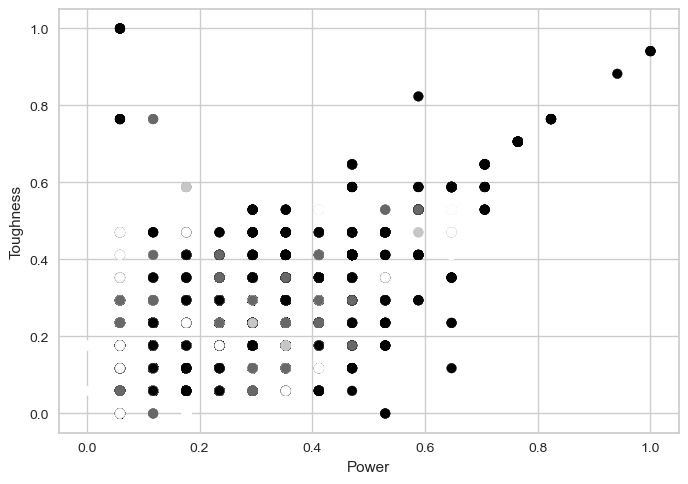

In [31]:
plt.scatter(X['power'], X['toughness'], c=X['clusters'])
plt.xlabel('Power')
plt.ylabel('Toughness')
plt.show()

In [35]:
# Calculate the mean or median value of each variable for each cluster
X.groupby('clusters').mean() # or 
cards.groupby('clusters').median()

# Compare the differences between the clusters
#X.groupby('clusters').mean().diff()

,convertedManaCost,power,toughness,edhrecRank,edhrecSaltiness,color_groups,amount_of_abilities,PC1,PC2,PC3,PC4
clusters,,,,,,,,,,,
0,3.0,0.0,0.0,10264.0,0.08,1.0,1.0,1.611108,1.597037,1.583269,1.532299
1,3.0,0.0,0.0,3796.0,0.19,1.0,1.0,1.601058,1.598887,1.585404,1.529720
2,2.0,0.0,1.0,13781.0,0.05,1.0,1.0,1.597207,1.611848,1.585262,1.530371
3,4.0,3.0,3.0,5739.0,0.16,1.0,1.0,1.605261,1.603178,1.576570,1.531962


In [46]:
cards.groupby('clusters').mean()

,convertedManaCost,power,toughness,edhrecRank,edhrecSaltiness,color_groups,amount_of_abilities,PC1,PC2,PC3,PC4
clusters,,,,,,,,,,,
0,3.011863,1.150750,1.274091,10694.778398,0.143047,1.132550,1.095769,1.539626,1.503288,1.500480,1.527262
1,3.193099,0.253748,0.284723,5809.824743,0.312521,1.121608,1.035312,1.523466,1.498031,1.503672,1.516589
2,2.576367,1.094097,1.186510,12754.891244,0.097259,1.033380,1.079190,1.518605,1.521188,1.485174,1.529924
3,4.225939,3.239021,3.427693,7333.226434,0.246169,1.352875,1.300545,1.535912,1.526166,1.504789,1.542791


In [50]:
cards_with_clusters = cards

In [51]:
cards_with_clusters.to_csv("cards_with_clusters")

In [9]:
cards = pd.read_csv('cards_with_clusters')

In [10]:
cards

,Unnamed: 0,name,colors,format,convertedManaCost,power,toughness,rarity,keywords,edhrecRank,types,edhrecSaltiness,color_groups,amount_of_abilities,PC1,PC2,PC3,PC4,clusters
0,0,Ancestor's Chosen,W,commander,7.0,4,4,uncommon,First strike,18998.0,Creature,0.27,1,1,0.741407,1.813086,1.563877,1.430453,0
1,9,Ancestor's Chosen,W,commander,7.0,4,4,uncommon,First strike,18998.0,Creature,0.27,1,1,1.044065,1.525808,1.808103,1.954702,0
2,18,Angel of Mercy,W,commander,5.0,3,3,uncommon,Flying,15286.0,Creature,0.00,1,1,1.049402,1.610594,1.752139,1.983006,0
3,31,Angel of Mercy,W,commander,5.0,3,3,uncommon,Flying,15286.0,Creature,0.00,1,1,1.603569,1.834481,0.643782,1.503330,0
4,44,Angelic Blessing,W,commander,3.0,0,0,common,empty,20402.0,Sorcery,0.14,1,1,1.782732,1.511603,1.764917,0.869109,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68931,718978,Into the Roil,U,commander,2.0,0,0,common,Kicker,1859.0,Instant,0.14,1,1,NaN,NaN,NaN,NaN,2
68932,718992,Bloodchief's Thirst,B,commander,1.0,0,0,uncommon,Kicker,6713.0,Sorcery,0.00,1,1,NaN,NaN,NaN,NaN,0
68933,719003,Roil Eruption,R,commander,2.0,0,0,common,Kicker,13187.0,Sorcery,0.08,1,1,NaN,NaN,NaN,NaN,2
68934,719016,Roiling Regrowth,G,commander,3.0,0,0,uncommon,empty,688.0,Instant,0.09,1,1,NaN,NaN,NaN,NaN,0


## Cluster Names and charachteristics
Cluster 0 - "Mid-Cost Creatures / Low-Cost Utility"

Median convertedManaCost of 3, and mean of 3.01
Median power and toughness values of 0 and 0 respectively, with mean values of 1.15 and 1.27 respectively, indicating a preference for creatures with low power and toughness but moderate cost. This cluster also has a low median edhrecSaltiness value of 0.14, indicating a lower average power level compared to other clusters. In terms of color, the cluster is dominated by single-color cards (color_groups = 1).
Can be applied to Magic: The Gathering in commander format by building a deck that utilizes these mid-cost creatures as early game blockers or to apply pressure to the opponent's life total. The cluster can also be used to build a utility-based deck, focusing on low-cost cards that provide a variety of effects and utility to the player.

Cluster 1 - "Low-Cost Spells / Low-Power Aggro"

Median convertedManaCost of 3, and mean of 3.19
Median power and toughness values of 0 and 0 respectively, with mean values of 0.25 and 0.28 respectively, indicating a preference for spells over creatures. This cluster has the lowest median edhrecSaltiness value of all clusters at 0.19, indicating a lower average power level compared to other clusters. The highest amount of cards in this cluster (nearly 70,000) suggests that it represents a common archetype in the game. In terms of color, the cluster is dominated by single-color cards (color_groups = 1).
Can be applied to Magic: The Gathering in commander format by building a low-cost aggro deck, focusing on quickly overwhelming the opponent with a large number of creatures with low mana costs. This cluster can also be used to build a control deck that utilizes low-cost spells to control the board state or to deal damage to the opponent's creatures or life total.

Cluster 2 - "Low-Cost Creatures / Midrange Control"

Median convertedManaCost of 2, and mean of 2.57, making it the cluster with the lowest cost. Median power and toughness values of 1 and 0 respectively, with mean values of 1.09 and 1.19 respectively, indicating a preference for low-cost creatures with decent power and toughness. This cluster has the lowest median edhrecRank value of all clusters at 12,754, indicating a lower popularity compared to other clusters. In terms of color, the cluster is dominated by single-color cards (color_groups = 1).
Can be applied to Magic: The Gathering in commander format by building a deck that utilizes these low-cost creatures as early game threats or as chump blockers to preserve life total. The cluster can also be used to build a control deck that focuses on board presence and outlasting the opponent through midrange creatures with efficient abilities.

Cluster 3 - "High-Cost Powerhouses / High-Power Beatdown"

Median convertedManaCost of 4, and mean of 4.23, making it the cluster with the highest cost. Median power and toughness values of 3 and 3 respectively, with mean values of 3.24 and 3.43 respectively, indicating a preference for high-cost creatures with high power and toughness. This cluster has a median edhrecSaltiness value of 0.25, indicating a higher average power level compared to other clusters. In terms of color, the cluster is dominated by multi-color cards (color_groups = 2).
Can be applied to Magic: The Gathering in commander format by building a deck that utilizes these high-cost creatures as finishers

## EDA 
To dig deeper into the analysis of the clusters and verify the cluster titles and traits, we can perform exploratory data analysis (EDA) using the columns in the 'cards' dataframe. Here are some steps we can take:

Verify the cluster titles and traits: We can start by checking the cards in each cluster to see if they fit the cluster's description based on their basic statistics. For example, we can check if Cluster 0 ("Mid-Cost Creatures / Low-Cost Utility") contains cards with moderate cost and low power and toughness, if Cluster 1 ("Low-Cost Spells / Low-Power Aggro") contains mostly spells with low cost and power/toughness, and so on. We can also check the rarity and types of the cards in each cluster to see if they match the expected archetypes.

Identify any unique or common keywords: We can check the 'keywords' column to identify any unique or common keywords that appear in each cluster. This can help us identify potential synergies or themes within the clusters.

Analyze the color distribution: We can check the 'colors' column to see which colors are dominant in each cluster. This can help us identify potential color-based strategies or synergies.

Investigate the format distribution: We can check the 'format' column to see which formats each cluster is most commonly used in. This can help us identify which formats each cluster is most suitable for.

Explore the PC values: We can analyze the principal component (PC) values in each cluster to see if there are any patterns or trends. For example, we can check if certain PC values are more dominant in certain clusters, which can help us identify potential themes or strategies.

Check the edhrecRank and edhrecSaltiness: We can analyze the edhrecRank and edhrecSaltiness values to see which clusters contain cards that are more popular or more niche. This can help us identify potential archetypes or strategies that are popular or uncommon in the game.

By performing EDA using these columns in the 'cards' dataframe, we can gain a deeper understanding of the clusters and potentially identify more useful insights for deck construction and in-game strategies.

In [11]:
# Define the titles for each cluster
cluster_titles = {
    0: "Mid-Cost Creatures / Low-Cost Utility",
    1: "Low-Cost Spells / Low-Power Aggro",
    2: "Low-Cost Creatures / Midrange Control",
    3: "High-Cost Powerhouses / High-Power Beatdown"
}

# Verify the cluster titles and traits
for cluster in range(4):
    cluster_name = cluster_titles[cluster].replace(" ", "_").replace("-", "_").replace("/", "_")
    print(f"\nCards in Cluster {cluster_titles[cluster]}:\n")
    cluster_cards = cards[cards["clusters"] == cluster]
    display(cluster_cards[["name", "colors", "convertedManaCost", "power", "toughness", "rarity", "types", "keywords"]].head(10))
    print("\nCluster Summary Statistics:\n")
    display(cluster_cards[["convertedManaCost", "power", "toughness", "edhrecSaltiness", "color_groups", "amount_of_abilities","keywords"]].describe(include='all'))
    
    # Save cluster as a csv
    cluster_cards.to_csv(f"{cluster_name}.csv", index=False)



Cards in Cluster Mid-Cost Creatures / Low-Cost Utility:



,name,colors,convertedManaCost,power,toughness,rarity,types,keywords
0,Ancestor's Chosen,W,7.0,4,4,uncommon,Creature,First strike
1,Ancestor's Chosen,W,7.0,4,4,uncommon,Creature,First strike
2,Angel of Mercy,W,5.0,3,3,uncommon,Creature,Flying
3,Angel of Mercy,W,5.0,3,3,uncommon,Creature,Flying
9,Aura of Silence,W,3.0,0,0,uncommon,Enchantment,empty
12,Ballista Squad,W,4.0,2,2,uncommon,Creature,empty
18,Condemn,W,1.0,0,0,uncommon,Instant,empty
24,Hail of Arrows,W,1.0,0,0,uncommon,Instant,empty
27,High Ground,W,1.0,0,0,uncommon,Enchantment,empty
32,Icatian Priest,W,1.0,1,1,uncommon,Creature,empty



Cluster Summary Statistics:



,convertedManaCost,power,toughness,edhrecSaltiness,color_groups,amount_of_abilities,keywords
count,18461.000000,18461.000000,18461.000000,18461.000000,18461.000000,18461.000000,18461
unique,NaN,NaN,NaN,NaN,NaN,NaN,690
top,NaN,NaN,NaN,NaN,NaN,NaN,empty
freq,NaN,NaN,NaN,NaN,NaN,NaN,11120
mean,3.011863,1.150750,1.274091,0.143047,1.132550,1.095769,NaN
std,1.660522,1.568816,1.668442,0.198759,0.367759,0.329045,NaN
min,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,NaN
25%,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
50%,3.000000,0.000000,0.000000,0.080000,1.000000,1.000000,NaN
75%,4.000000,2.000000,2.000000,0.200000,1.000000,1.000000,NaN



Cards in Cluster Low-Cost Spells / Low-Power Aggro:



,name,colors,convertedManaCost,power,toughness,rarity,types,keywords
6,Angelic Chorus,W,5.0,0,0,rare,Enchantment,empty
14,Beacon of Immortality,W,6.0,0,0,rare,Instant,empty
23,Glorious Anthem,W,3.0,0,0,rare,Enchantment,empty
37,Mobilization,W,3.0,0,0,rare,Enchantment,empty
38,Mobilization,W,3.0,0,0,rare,Enchantment,empty
45,Pariah,W,3.0,0,0,rare,Enchantment,Enchant
46,Pariah,W,3.0,0,0,rare,Enchantment,Enchant
50,Righteousness,W,1.0,0,0,rare,Instant,empty
70,Story Circle,W,3.0,0,0,rare,Enchantment,empty
89,Wrath of God,W,4.0,0,0,rare,Sorcery,empty



Cluster Summary Statistics:



,convertedManaCost,power,toughness,edhrecSaltiness,color_groups,amount_of_abilities,keywords
count,16142.000000,16142.000000,16142.000000,16142.000000,16142.000000,16142.000000,16142
unique,NaN,NaN,NaN,NaN,NaN,NaN,273
top,NaN,NaN,NaN,NaN,NaN,NaN,empty
freq,NaN,NaN,NaN,NaN,NaN,NaN,11788
mean,3.193099,0.253748,0.284723,0.312521,1.121608,1.035312,NaN
std,2.154711,1.075452,1.156097,0.385289,0.368371,0.195652,NaN
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
25%,2.000000,0.000000,0.000000,0.070000,1.000000,1.000000,NaN
50%,3.000000,0.000000,0.000000,0.190000,1.000000,1.000000,NaN
75%,5.000000,0.000000,0.000000,0.400000,1.000000,1.000000,NaN



Cards in Cluster Low-Cost Creatures / Midrange Control:



,name,colors,convertedManaCost,power,toughness,rarity,types,keywords
4,Angelic Blessing,W,3.0,0,0,common,Sorcery,empty
5,Angelic Blessing,W,3.0,0,0,common,Sorcery,empty
7,Angelic Wall,W,2.0,0,4,common,Creature,"Defender,Flying"
8,Angelic Wall,W,2.0,0,4,common,Creature,"Defender,Flying"
10,Aven Cloudchaser,W,4.0,2,2,common,Creature,Flying
11,Aven Cloudchaser,W,4.0,2,2,common,Creature,Flying
13,Bandage,W,1.0,0,0,common,Instant,empty
15,Benalish Knight,W,3.0,2,2,common,Creature,"First strike,Flash"
16,Benalish Knight,W,3.0,2,2,common,Creature,"First strike,Flash"
19,Demystify,W,1.0,0,0,common,Instant,empty



Cluster Summary Statistics:



,convertedManaCost,power,toughness,edhrecSaltiness,color_groups,amount_of_abilities,keywords
count,20192.000000,20192.000000,20192.000000,20192.000000,20192.000000,20192.000000,20192
unique,NaN,NaN,NaN,NaN,NaN,NaN,735
top,NaN,NaN,NaN,NaN,NaN,NaN,empty
freq,NaN,NaN,NaN,NaN,NaN,NaN,11878
mean,2.576367,1.094097,1.186510,0.097259,1.033380,1.079190,NaN
std,1.482506,1.402701,1.490724,0.132164,0.189034,0.288486,NaN
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
25%,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
50%,2.000000,0.000000,1.000000,0.050000,1.000000,1.000000,NaN
75%,3.000000,2.000000,2.000000,0.140000,1.000000,1.000000,NaN



Cards in Cluster High-Cost Powerhouses / High-Power Beatdown:



,name,colors,convertedManaCost,power,toughness,rarity,types,keywords
17,"Cho-Manno, Revolutionary",W,4.0,2,2,rare,Creature,empty
20,Field Marshal,W,3.0,2,2,rare,Creature,empty
21,Field Marshal,W,3.0,2,2,rare,Creature,empty
33,Kjeldoran Royal Guard,W,5.0,2,5,rare,Creature,empty
35,Loyal Sentry,W,1.0,1,1,rare,Creature,empty
39,Nomad Mythmaker,W,3.0,2,2,rare,Creature,empty
40,Nomad Mythmaker,W,3.0,2,2,rare,Creature,empty
43,Paladin en-Vec,W,3.0,2,2,rare,Creature,"First strike,Protection"
44,Paladin en-Vec,W,3.0,2,2,rare,Creature,"First strike,Protection"
48,Reya Dawnbringer,W,9.0,4,6,rare,Creature,Flying



Cluster Summary Statistics:



,convertedManaCost,power,toughness,edhrecSaltiness,color_groups,amount_of_abilities,keywords
count,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141
unique,NaN,NaN,NaN,NaN,NaN,NaN,796
top,NaN,NaN,NaN,NaN,NaN,NaN,empty
freq,NaN,NaN,NaN,NaN,NaN,NaN,5468
mean,4.225939,3.239021,3.427693,0.246169,1.352875,1.300545,NaN
std,1.865057,2.042583,2.034694,0.309446,0.701945,0.638946,NaN
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
25%,3.000000,2.000000,2.000000,0.050000,1.000000,1.000000,NaN
50%,4.000000,3.000000,3.000000,0.160000,1.000000,1.000000,NaN
75%,5.000000,4.000000,5.000000,0.310000,2.000000,1.000000,NaN


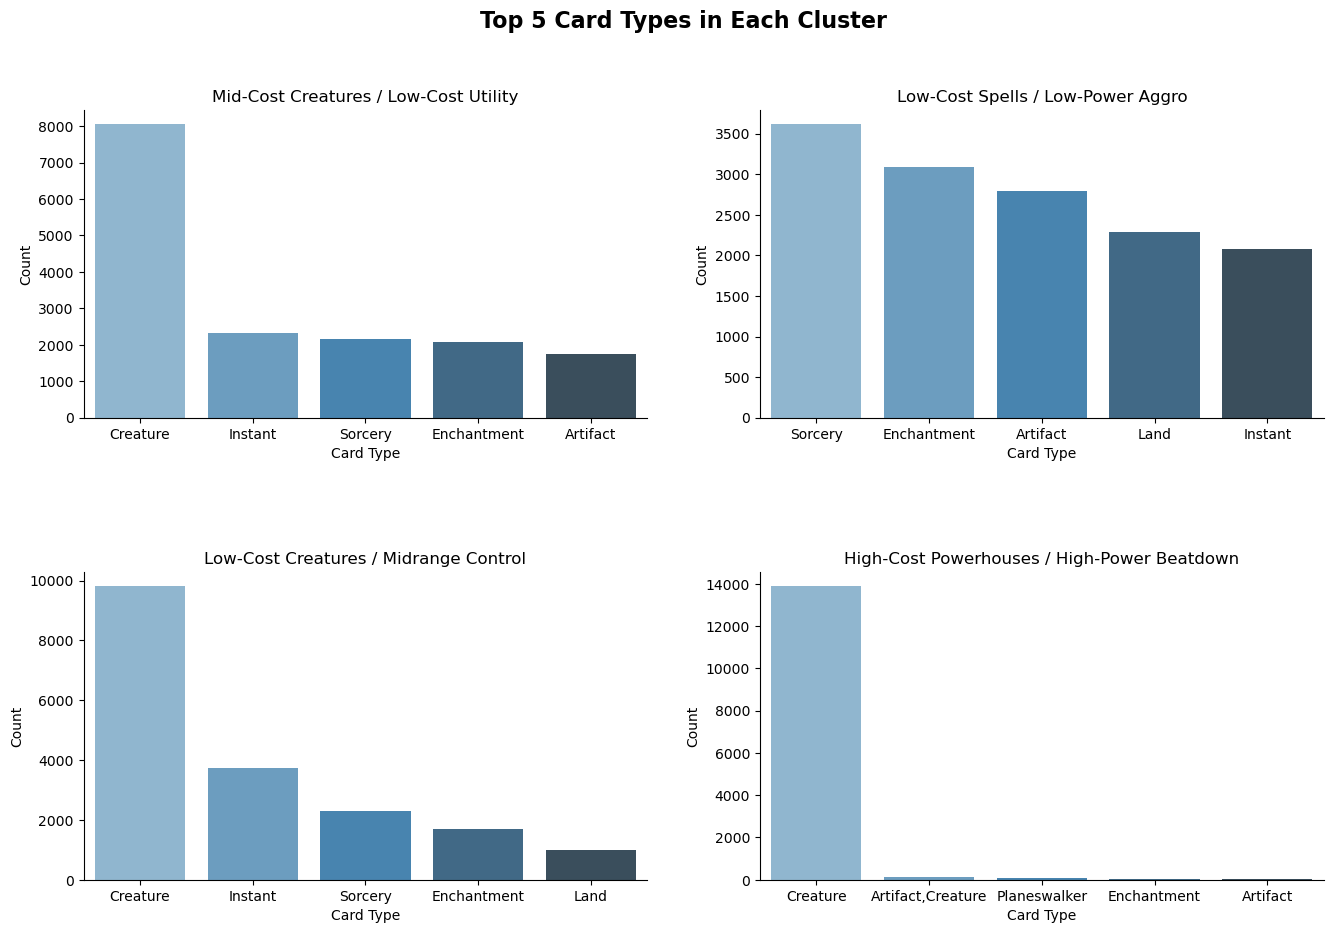

In [117]:
# Define the titles for each cluster
cluster_titles = {
    0: "Mid-Cost Creatures / Low-Cost Utility",
    1: "Low-Cost Spells / Low-Power Aggro",
    2: "Low-Cost Creatures / Midrange Control",
    3: "High-Cost Powerhouses / High-Power Beatdown"
}

cluster_type_counts = {}
for cluster in range(4):
    # Get the cards in the current cluster
    cluster_cards = cards[cards["clusters"] == cluster]

    # Count the number of cards for each type in the current cluster
    type_counts = cluster_cards["types"].str.split().explode().value_counts()

    # Add the type counts for the current cluster to the dictionary
    cluster_type_counts[cluster] = type_counts
    
# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axs = axs.flatten()

# Iterate over each cluster
for cluster in range(4):
    # Get the top 5 card types for the current cluster
    top_types = cluster_type_counts[cluster][:5]

    # Create a bar plot of the top 5 card types for the current cluster
    sns.barplot(x=top_types.index, y=top_types.values, ax=axs[cluster], palette='Blues_d')
    axs[cluster].set_title(cluster_titles[cluster])
    axs[cluster].set_xlabel('Card Type')
    axs[cluster].set_ylabel('Count')
    
    # Set the x-axis tick labels vertically to improve readability
    axs[cluster].set_xticklabels(top_types.index, rotation=0)
    
    # Hide the top and right spines to reduce chartjunk
    axs[cluster].spines['right'].set_visible(False)
    axs[cluster].spines['top'].set_visible(False)

# Add a main title to the figure
fig.suptitle('Top 5 Card Types in Each Cluster', fontsize=16, fontweight='bold')

# Adjust the spacing between subplots to improve readability
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# Save the figure
plt.savefig('top_card_types_per_cluster.png', dpi=300, bbox_inches='tight')
plt.show()


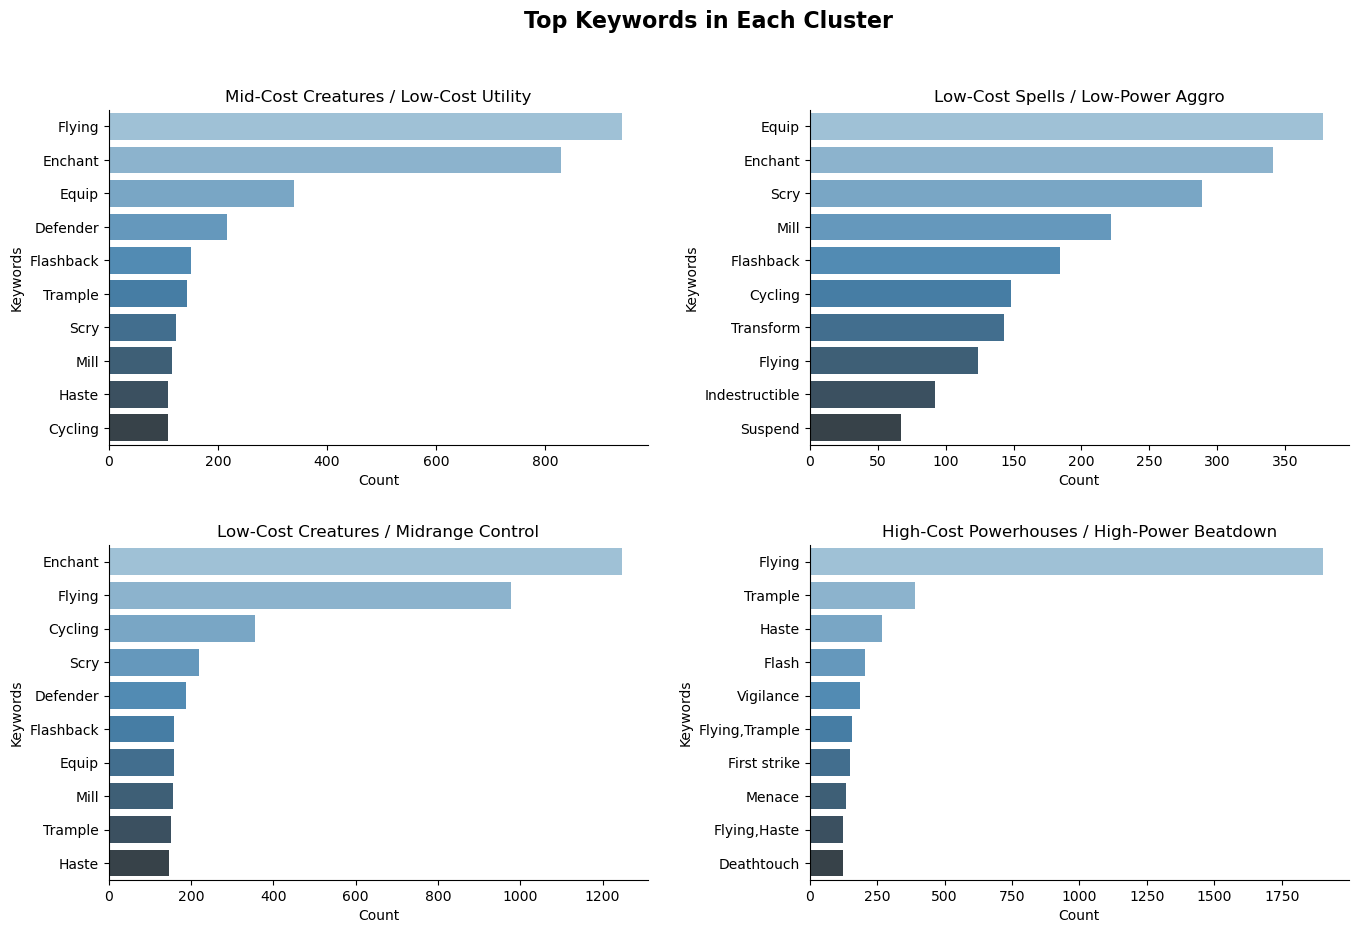

In [118]:
# Define the function to get the top non-empty keywords in a cluster
def get_top_keywords(cluster_group):
    keyword_counts = {}

    for keywords in cluster_group['keywords']:
        if pd.isna(keywords):
            continue
        for keyword in keywords.split(';'):
            keyword = keyword.strip()
            if keyword and keyword != 'empty':
                if keyword not in keyword_counts:
                    keyword_counts[keyword] = 1
                else:
                    keyword_counts[keyword] += 1

    top_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    top_keywords = pd.DataFrame(top_keywords, columns=['keywords', 'count'])
    return top_keywords

# Group the data by cluster and get the top keywords for each cluster
grouped_data = cards.groupby('clusters')
top_keywords = grouped_data.apply(get_top_keywords).reset_index()

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axs = axs.flatten()

# Iterate over each cluster
for cluster in range(4):
    # Get the top 10 keywords for the current cluster
    top_keywords_cluster = top_keywords[top_keywords['clusters'] == cluster][:10]

    # Create a bar plot of the top 10 keywords for the current cluster
    sns.barplot(x='count', y='keywords', data=top_keywords_cluster, ax=axs[cluster], palette='Blues_d')
    axs[cluster].set_title(cluster_titles[cluster])
    axs[cluster].set_xlabel('Count')
    axs[cluster].set_ylabel('Keywords')
    
    # Hide the top and right spines to reduce chartjunk
    axs[cluster].spines['right'].set_visible(False)
    axs[cluster].spines['top'].set_visible(False)

# Add a main title to the figure
fig.suptitle('Top Keywords in Each Cluster', fontsize=16, fontweight='bold')

# Adjust the spacing between subplots to improve readability
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Save the figure

plt.show()


In [114]:
color_palette = ['#F8E7B9', '#0E68AB', '#150B00', '#D3202A', '#00733E']
sns.set_palette(color_palette)

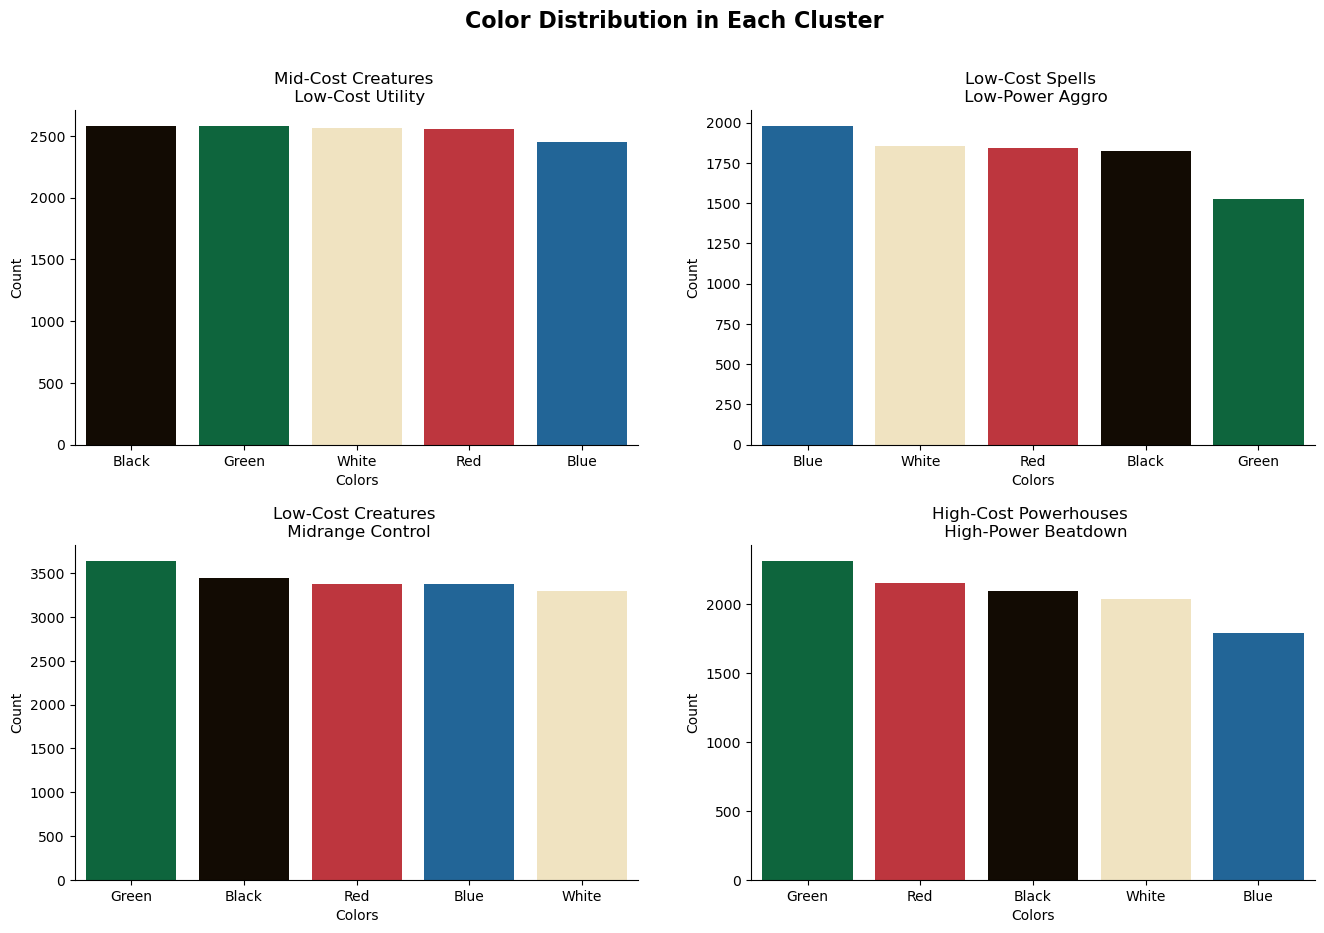

In [123]:
# Define the list of color categories and their names
color_categories = ['W', 'U', 'B', 'R', 'G']

# Define the dictionary to map color categories to color names
color_names = {
    'W': 'White',
    'U': 'Blue',
    'B': 'Black',
    'R': 'Red',
    'G': 'Green'
}

color_palette = {
    'W': '#F8E7B9',
    'U': '#0E68AB',
    'B': '#150B00',
    'R': '#D3202A',
    'G': '#00733E'
}



# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axs = axs.flatten()

# Iterate over each cluster
for cluster in range(4):
    # Get the cards in the current cluster
    cluster_cards = cards[cards["clusters"] == cluster]

    # Count the number of cards for each color category in the current cluster
    color_counts = cluster_cards['colors'].explode().value_counts()[color_categories]

    # Create a bar plot of the color category counts for the current cluster
    sns.barplot(x=color_counts.index, y=color_counts.values, ax=axs[cluster], order=color_counts.sort_values(ascending=False).index, palette=color_palette)

    # Set the title and axis labels for the plot
    axs[cluster].set_title(cluster_titles[cluster])
    axs[cluster].set_xlabel('Colors')
    axs[cluster].set_ylabel('Count')

    # Set the x-axis tick labels vertically to improve readability
    axs[cluster].set_xticklabels(axs[cluster].get_xticklabels(), rotation=0)
    for label in axs[cluster].get_xticklabels():
        category = label.get_text()
        name = color_names.get(category, category)
        label.set_text(name)
        
    # Set the x-axis tick labels
    axs[cluster].set_xticklabels(axs[cluster].get_xticklabels(), rotation=0)
    # Hide the top and right spines to reduce chartjunk
    axs[cluster].spines['right'].set_visible(False)
    axs[cluster].spines['top'].set_visible(False)

# Add a main title to the figure
fig.suptitle('Color Distribution in Each Cluster', fontsize=16, fontweight='bold')

# Adjust the spacing between subplots to improve readability
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# Save the figure
plt.savefig('color_distribution_per_cluster.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


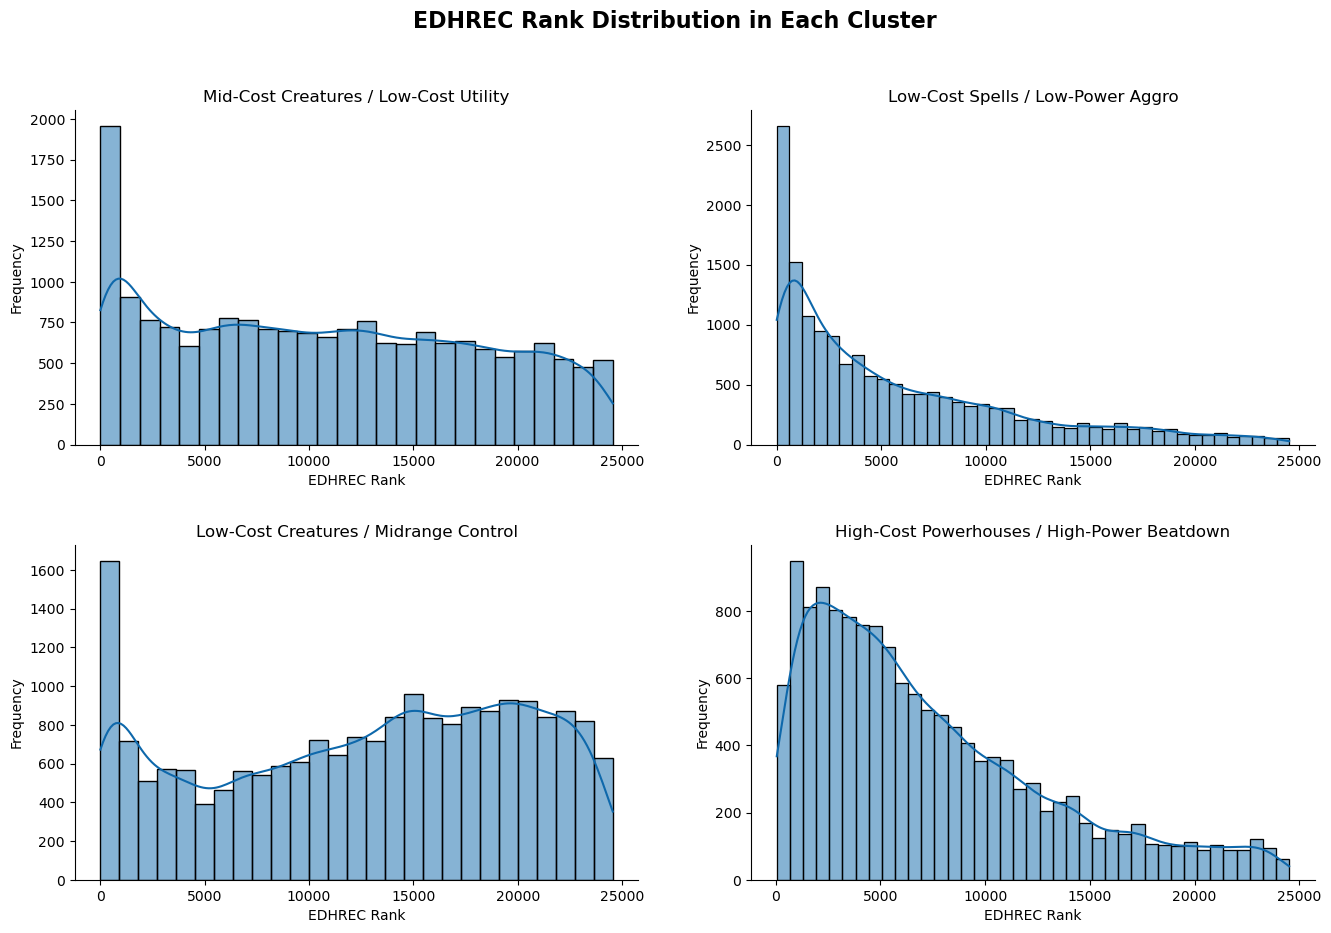

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the titles for each cluster
cluster_titles = {
    0: "Mid-Cost Creatures / Low-Cost Utility",
    1: "Low-Cost Spells / Low-Power Aggro",
    2: "Low-Cost Creatures / Midrange Control",
    3: "High-Cost Powerhouses / High-Power Beatdown"
}

# Define the list of color categories to count
color_categories = ['W', 'U', 'B', 'R', 'G']

# Define the color palette as a list of RGB tuples
color_palette = {
    'W': '#F8E7B9',  # yellow
    'U': '#0E68AB',  # blue
    'B': '#150B00',  # black
    'R': '#D3202A',  # red
    'G': '#00733E'   # green
}

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axs = axs.flatten()

# Iterate over each cluster
for cluster in range(4):
    # Get the cards in the current cluster
    cluster_cards = cards[cards["clusters"] == cluster]

    # Create a histogram of the edhrecRank for the current cluster
    sns.histplot(x=cluster_cards['edhrecRank'], ax=axs[cluster], kde=True, color=color_palette['U'])

    # Set the title and axis labels for the plot
    axs[cluster].set_title(cluster_titles[cluster])
    axs[cluster].set_xlabel('EDHREC Rank')
    axs[cluster].set_ylabel('Frequency')

    # Hide the top and right spines to reduce chartjunk
    axs[cluster].spines['right'].set_visible(False)
    axs[cluster].spines['top'].set_visible(False)

# Add a main title to the figure
fig.suptitle('EDHREC Rank Distribution in Each Cluster', fontsize=16, fontweight='bold')

# Adjust the spacing between subplots to improve readability
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# Save the figure
plt.savefig('edhrec_rank_per_cluster.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


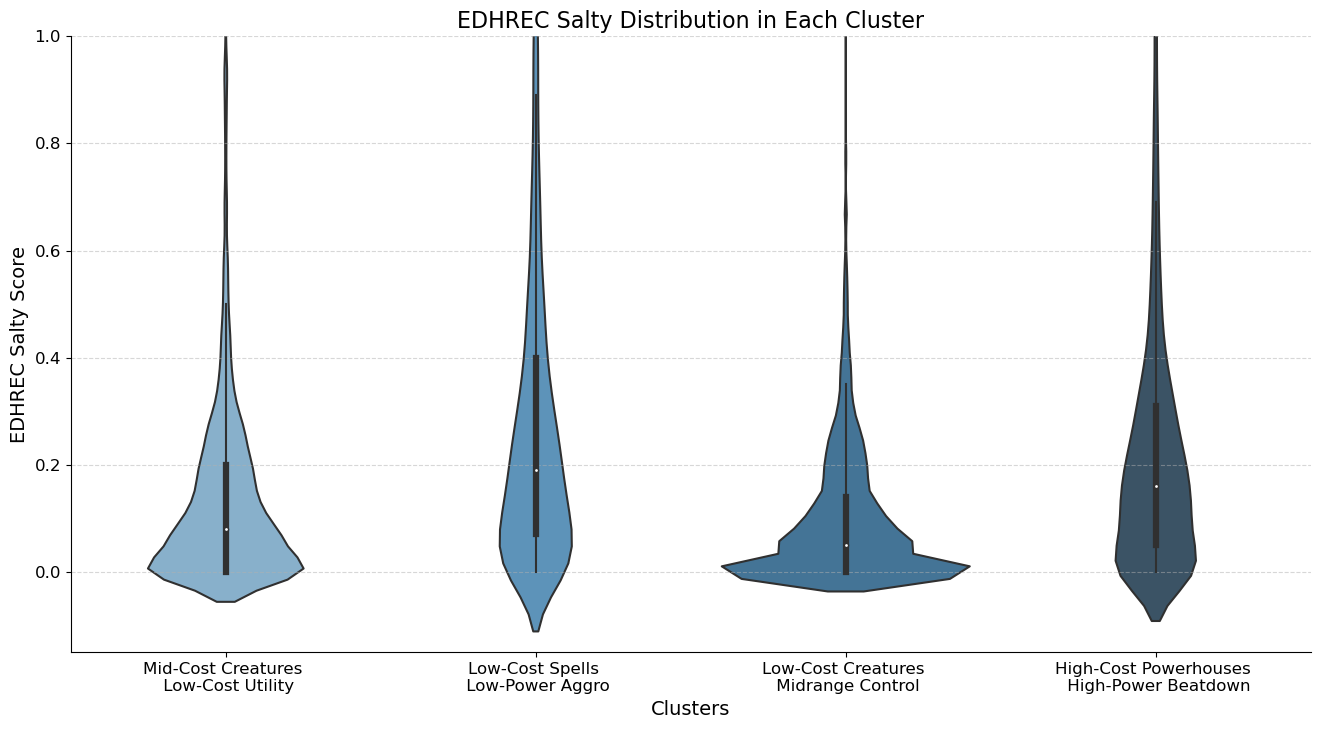

In [124]:
# Define the titles for each cluster
cluster_titles = {
    0: "Mid-Cost Creatures \n Low-Cost Utility",
    1: "Low-Cost Spells \n Low-Power Aggro",
    2: "Low-Cost Creatures \n Midrange Control",
    3: "High-Cost Powerhouses \n High-Power Beatdown"
}

# Create a violin plot to visualize the distribution of EDHREC salinity scores across clusters
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x='clusters', y='edhrecSaltiness', data=cards, order=[0, 1, 2, 3], palette='Blues_d')

# Set the title and axis labels for the plot
ax.set_title('EDHREC Salty Distribution in Each Cluster', fontsize=16)
ax.set_xlabel('Clusters', fontsize=14)
ax.set_ylabel('EDHREC Salty Score', fontsize=14)

# Set the x-axis tick labels to the cluster titles and rotate them for readability
ax.set_xticklabels([cluster_titles[i] for i in range(4)], rotation=0, ha='center')

# Set the y-axis tick labels to integers and add a comma separator for readability
#ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_ylim(-.15,1)
# Set the axis tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a horizontal grid to aid in reading the plot
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# Adjust the plot layout to prevent the title from overlapping with the plot
#fig.tight_layout()
plt.savefig('edhrec_saltiness.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


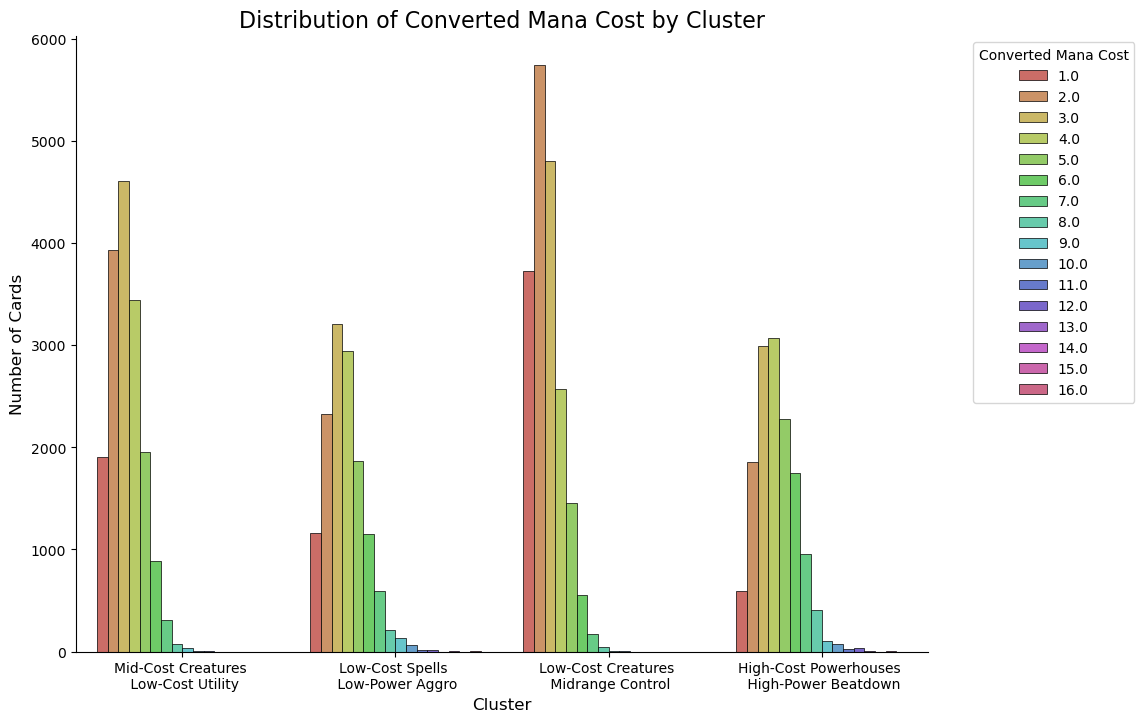

In [125]:
# Define the cluster titles
cluster_titles = {
    0: "Mid-Cost Creatures \n Low-Cost Utility",
    1: "Low-Cost Spells \n Low-Power Aggro",
    2: "Low-Cost Creatures \n Midrange Control",
    3: "High-Cost Powerhouses \n High-Power Beatdown"
}

# Generate a palette with 16 distinct colors
palette = sns.color_palette('hls', 16)

# Create a new DataFrame with two columns, 'clusters' and 'convertedManaCost'
cmc_df = cards[['clusters', 'convertedManaCost']]
cmc_df = cmc_df.dropna(subset=['convertedManaCost'])
cmc_df = cmc_df[cmc_df['convertedManaCost'] > 0]

# Count the number of cards by converted mana cost and cluster
cmc_counts = cmc_df.groupby(['convertedManaCost', 'clusters']).size().reset_index(name='count')

# Create a bar chart of the distribution of converted mana cost by cluster
fig, ax = plt.subplots(figsize=(11, 8))
sns.barplot(data=cmc_counts, x='clusters', y='count', hue='convertedManaCost', palette=palette, edgecolor='k', linewidth=0.5)
plt.xticks(range(4), [cluster_titles[i] for i in range(4)], rotation=0)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)
plt.title('Distribution of Converted Mana Cost by Cluster', fontsize=16)
plt.legend(title='Converted Mana Cost', loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=10)
sns.despine()
plt.savefig('concerted_mana.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
cards.colum

Index(['Unnamed: 0', 'name', 'colors', 'format', 'convertedManaCost', 'power',
       'toughness', 'rarity', 'keywords', 'edhrecRank', 'types',
       'edhrecSaltiness', 'color_groups', 'amount_of_abilities', 'PC1', 'PC2',
       'PC3', 'PC4', 'clusters'],
      dtype='object')